In [ ]:
# import numpy as np

# def pearson_r(x, y):
#     """
#     Compute Pearson correlation coefficient between x and y,
#     ignoring NaN values.
#     """
#     if x.shape != y.shape:
#         return np.nan
#     valid = ~np.isnan(x) & ~np.isnan(y)
#     x_valid = x[valid]
#     y_valid = y[valid]
#     n = len(x_valid)
#     if n == 0:
#         return np.nan
#     meanx = np.mean(x_valid)
#     meany = np.mean(y_valid)
#     varx = np.sum(x_valid * x_valid) / n - meanx**2
#     vary = np.sum(y_valid * y_valid) / n - meany**2
#     cov = np.sum(x_valid * y_valid) / n - meanx * meany
#     return cov / np.sqrt(varx * vary)

# def CCM_mat(X, Ydata, E, L, tau=1, b=None):
#     """
#     Convergent Cross Mapping (CCM) as in Sugihara et al., 2012.
    
#     Parameters:
#       X     : 1D array (predictor variable time series)
#       Ydata : 2D array (target variable(s); if 1D, it will be reshaped to column vector)
#       E     : Embedding dimension
#       L     : Library length; if provided as an array, the function loops over its elements.
#       tau   : Time lag for embedding (default 1)
#       b     : Number of points for simplex averaging (default E+1)
    
#     Returns a dictionary with keys:
#       'N'   : Number of data points used (after embedding)
#       'L'   : The used library length (scalar)
#       'rho' : CCM correlation(s) (averaged over all library sets)
#       'mae' : Mean absolute error
#       'rmse': Root mean square error
#     """
#     if b is None:
#         b = E + 1

#     # Ensure X is a 1D numpy array and Ydata is at least 2D.
#     X = np.asarray(X).flatten()
#     Ydata = np.atleast_2d(Ydata)
#     if Ydata.shape[0] != X.shape[0]:
#         # If necessary, transpose Ydata.
#         Ydata = Ydata.T
#     nY = Ydata.shape[1]

#     # If L is a vector, loop over its elements.
#     L = np.atleast_1d(L)
#     if L.size > 1:
#         results_rho = np.zeros((L.size, nY))
#         results_mae = np.zeros((L.size, nY))
#         results_rmse = np.zeros((L.size, nY))
#         for i, Li in enumerate(L):
#             res = CCM_mat(X, Ydata, E, Li, tau, b)
#             results_rho[i, :] = res['rho']
#             results_mae[i, :] = res['mae']
#             results_rmse[i, :] = res['rmse']
#         return {'N': res['N'], 'L': L, 'rho': results_rho, 'mae': results_mae, 'rmse': results_rmse}

#     # Now L is a scalar.
#     L = L.item()
#     if L - E + 1 < b:
#         b = L - E + 1

#     nX = len(X)
#     # Create the embedding (lagsX) with shape (nX, E), filled with NaN.
#     lagsX = np.full((nX, E), np.nan)
#     for i in range(E):
#         ilag = i * tau
#         if ilag < nX:
#             lagsX[ilag:, i] = X[:nX - ilag]
#     # Crop the embedding and Ydata from index (E-1)*tau to the end.
#     start_idx = (E - 1) * tau
#     lagsX = lagsX[start_idx:, :]
#     Ydata = Ydata[start_idx:, :]
#     N = lagsX.shape[0]

#     # The library size cannot exceed N.
#     if L > N:
#         L = N

#     # Create library index masks.
#     if L == N:
#         Lstart = np.array([0])  # 0-indexed start.
#         Lndx = np.ones((1, N), dtype=bool)
#     else:
#         Lstart = np.arange(N)
#         Lndx = np.zeros((Lstart.size, N), dtype=bool)
#         for i, s in enumerate(Lstart):
#             ndx1 = np.arange(s, s + L)
#             # Apply periodic boundaries.
#             ndx1 = np.mod(ndx1, N)
#             Lndx[i, ndx1] = True

#     # Initialize predicted Y values: shape (N, number of library sets, nY).
#     Ypred = np.full((N, Lstart.size, nY), np.nan)

#     # Loop over each point in the embedded space.
#     for i in range(N):
#         diff = lagsX - lagsX[i, :]  # Differences with shape (N, E)
#         Dtot = np.sqrt(np.nansum(diff**2, axis=1))
#         # Leave-one-out: ignore the i-th point.
#         Dtot[i] = np.nan
#         for k in range(Lstart.size):
#             idx_lib = Lndx[k, :]
#             D = Dtot[idx_lib]
#             Yobs1 = Ydata[idx_lib, :]  # Corresponding Y values.
#             # Replace NaNs with infinity for sorting.
#             D_for_sort = np.where(np.isnan(D), np.inf, D)
#             # Find indices of the b+1 smallest distances.
#             sorted_idx = np.argsort(D_for_sort)[:(b+1)]
#             Dmx = D_for_sort[sorted_idx]
#             inm = sorted_idx.copy()
#             # Check for ties: compare the b-th and (b+1)-th smallest distances.
#             has_ties = False
#             if len(Dmx) > b and np.isclose(Dmx[b], Dmx[b-1]):
#                 has_ties = True
#             if has_ties:
#                 tiedistance = Dmx[b-1]
#                 # Include all indices where D equals tiedistance.
#                 tie_idx = np.where(np.isclose(D, tiedistance))[0]
#                 # Combine indices not equal to the tiedistance from the sorted list with all tie indices.
#                 inm = np.concatenate((inm[Dmx[:b] != tiedistance], tie_idx))
#                 Dmx = D_for_sort[inm]
#             else:
#                 # Remove the extra slot.
#                 inm = inm[:b]
#                 Dmx = Dmx[:b]
            
#             # Compute weights using inverse distance weighting.
#             if Dmx[0] > 0:
#                 u = np.exp(-Dmx / Dmx[0])
#                 u[u < 1e-6] = 1e-6
#             else:
#                 u = np.full_like(Dmx, 1e-5)
#                 u[np.isclose(Dmx, 0)] = 1
#             if has_ties:
#                 tie_ndx = np.where(np.isclose(Dmx, tiedistance))[0]
#                 if tie_ndx.size > 0:
#                     adjustfactor = (b - tie_ndx[0] + 1) / tie_ndx.size
#                     u[tie_ndx] = u[tie_ndx] * adjustfactor
#             # Weighted average of the observed Y values.
#             weighted_sum = np.dot(u, Yobs1[inm, :])
#             Ypred[i, k, :] = weighted_sum / np.sum(u)
    
#     # Compute statistics for each library set and for each column of Ydata.
#     rho = np.full((Lstart.size, nY), np.nan)
#     mae = np.full((Lstart.size, nY), np.nan)
#     rmse = np.full((Lstart.size, nY), np.nan)
    
#     for k in range(Lstart.size):
#         for j in range(nY):
#             Ypred1 = Ypred[:, k, j]
#             valid = ~np.isnan(Ypred1) & ~np.isnan(Ydata[:, j])
#             Ypred_valid = Ypred1[valid]
#             Yobs_valid = Ydata[valid, j]
#             if Yobs_valid.size > 0:
#                 rho[k, j] = pearson_r(Yobs_valid, Ypred_valid)
#                 mae[k, j] = np.mean(np.abs(Yobs_valid - Ypred_valid))
#                 rmse[k, j] = np.sqrt(np.mean((Yobs_valid - Ypred_valid)**2))
    
#     # Average the statistics over library sets.
#     final_rho = np.nanmean(rho, axis=0)
#     final_mae = np.nanmean(mae, axis=0)
#     final_rmse = np.nanmean(rmse, axis=0)
    
#     results = {'N': N, 'L': L, 'rho': final_rho, 'mae': final_mae, 'rmse': final_rmse}
#     return results



In [6]:
import numpy as np

def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient between x and y,
    ignoring NaN values.
    """
    if x.shape != y.shape:
        return np.nan
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]
    n = len(x_valid)
    if n == 0:
        return np.nan
    meanx = np.mean(x_valid)
    meany = np.mean(y_valid)
    varx = np.sum(x_valid**2) / n - meanx**2
    vary = np.sum(y_valid**2) / n - meany**2
    cov = np.sum(x_valid * y_valid) / n - meanx * meany
    return cov / np.sqrt(varx * vary)

def CCM_mat(X, Ydata, E, L, tau=1, b=None):
    """
    Convergent Cross Mapping (CCM) as in Sugihara et al., 2012.

    Parameters:
      X     : 1D array (predictor time series)
      Ydata : 2D array (target variable(s); if 1D, reshaped to a column vector)
      E     : Embedding dimension
      L     : Library length; if an array, loop over its elements.
      tau   : Time lag for embedding (default=1)
      b     : Number of points for simplex averaging (default = E+1)

    Returns a dictionary with keys:
      'N'   : Number of data points used after embedding
      'L'   : Used library length (scalar)
      'rho' : CCM correlation(s) (averaged over library sets)
      'mae' : Mean absolute error
      'rmse': Root mean square error
    """
    if b is None:
        b = E + 1

    X = np.asarray(X).flatten()
    Ydata = np.atleast_2d(Ydata)
    if Ydata.shape[0] != X.shape[0]:
        Ydata = Ydata.T
    nY = Ydata.shape[1]

    L = np.atleast_1d(L)
    if L.size > 1:
        results_rho = np.zeros((L.size, nY))
        results_mae = np.zeros((L.size, nY))
        results_rmse = np.zeros((L.size, nY))
        for i, Li in enumerate(L):
            res = CCM_mat(X, Ydata, E, Li, tau, b)
            results_rho[i, :] = res['rho']
            results_mae[i, :] = res['mae']
            results_rmse[i, :] = res['rmse']
        return {'N': res['N'], 'L': L, 'rho': results_rho, 'mae': results_mae, 'rmse': results_rmse}

    L = L.item()
    if L - E + 1 < b:
        b = L - E + 1

    nX = len(X)
    lagsX = np.full((nX, E), np.nan)
    for i in range(E):
        ilag = i * tau
        if ilag < nX:
            lagsX[ilag:, i] = X[:nX - ilag]
    start_idx = (E - 1) * tau
    lagsX = lagsX[start_idx:, :]
    Ydata = Ydata[start_idx:, :]
    N = lagsX.shape[0]
    if L > N:
        L = N

    if L == N:
        Lstart = np.array([0])
        Lndx = np.ones((1, N), dtype=bool)
    else:
        Lstart = np.arange(N)
        Lndx = np.zeros((Lstart.size, N), dtype=bool)
        for i, s in enumerate(Lstart):
            ndx1 = np.arange(s, s + L)
            ndx1 = np.mod(ndx1, N)
            Lndx[i, ndx1] = True

    n_lib = Lstart.size
    Ypred = np.full((N, n_lib, nY), np.nan)
    for i in range(N):
        diff = lagsX - lagsX[i, :]
        Dtot = np.sqrt(np.nansum(diff**2, axis=1))
        Dtot[i] = np.nan  # leave-one-out
        for k in range(n_lib):
            idx_lib = Lndx[k, :]
            D = Dtot[idx_lib]
            Yobs1 = Ydata[idx_lib, :]
            D_for_sort = np.where(np.isnan(D), np.inf, D)
            sorted_idx = np.argsort(D_for_sort)[:(b+1)]
            Dmx = D_for_sort[sorted_idx]
            inm = sorted_idx.copy()
            has_ties = False
            if len(Dmx) > b and np.isclose(Dmx[b], Dmx[b-1]):
                has_ties = True
            if has_ties:
                tiedistance = Dmx[b-1]
                tie_idx = np.where(np.isclose(D, tiedistance))[0]
                # Use inm[:b] (first b elements) for the boolean indexing:
                inm = np.concatenate((inm[:b][Dmx[:b] != tiedistance], tie_idx))
                Dmx = D_for_sort[inm]
            else:
                inm = inm[:b]
                Dmx = Dmx[:b]
            if Dmx[0] > 0:
                u = np.exp(-Dmx / Dmx[0])
                u[u < 1e-6] = 1e-6
            else:
                u = np.full_like(Dmx, 1e-5)
                u[np.isclose(Dmx, 0)] = 1
            if has_ties:
                tie_ndx = np.where(np.isclose(Dmx, tiedistance))[0]
                if tie_ndx.size > 0:
                    adjustfactor = (b - tie_ndx[0] + 1) / tie_ndx.size
                    u[tie_ndx] = u[tie_ndx] * adjustfactor
            weighted_sum = np.dot(u, Yobs1[inm, :])
            Ypred[i, k, :] = weighted_sum / np.sum(u)
    rho = np.full((n_lib, nY), np.nan)
    mae = np.full((n_lib, nY), np.nan)
    rmse = np.full((n_lib, nY), np.nan)
    for k in range(n_lib):
        for j in range(nY):
            Ypred1 = Ypred[:, k, j]
            valid = ~np.isnan(Ypred1) & ~np.isnan(Ydata[:, j])
            Ypred_valid = Ypred1[valid]
            Yobs_valid = Ydata[valid, j]
            if Yobs_valid.size > 0:
                rho[k, j] = pearson_r(Yobs_valid, Ypred_valid)
                mae[k, j] = np.mean(np.abs(Yobs_valid - Ypred_valid))
                rmse[k, j] = np.sqrt(np.mean((Yobs_valid - Ypred_valid)**2))
    final_rho = np.nanmean(rho, axis=0)
    final_mae = np.nanmean(mae, axis=0)
    final_rmse = np.nanmean(rmse, axis=0)
    return {'N': N, 'L': L, 'rho': final_rho, 'mae': final_mae, 'rmse': final_rmse}

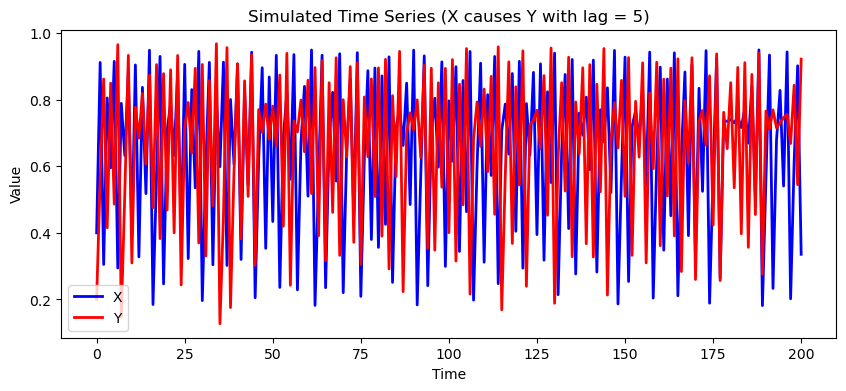

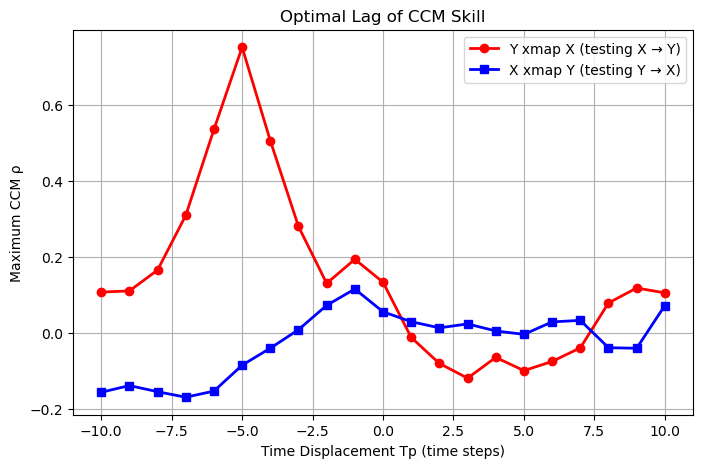

In [5]:
import numpy as np
import matplotlib.pyplot as plt




# ---------------------------
# Simulation: Coupled Logistic Map (X causes Y with a lag)
# ---------------------------
r_x = 3.8        # growth rate for X
r_y = 3.5        # growth rate for Y
B_yx = 0.1       # coupling coefficient: influence of X on Y
LAG = 5          # lag (in time steps) by which X influences Y
t_total = 200    # number of time steps

X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.4
Y[0] = 0.2

for t in range(t_total):
    X[t+1] = r_x * X[t] * (1 - X[t])
    if (t + 1) < LAG:
        Y[t+1] = r_y * Y[t] * (1 - Y[t])
    else:
        Y[t+1] = r_y * Y[t] * (1 - Y[t]) + B_yx * X[t - LAG + 1]

time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, 'b-', linewidth=2, label='X')
plt.plot(time, Y, 'r-', linewidth=2, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Simulated Time Series (X causes Y with lag = {LAG})')
plt.legend()
plt.show()

# ---------------------------
# CCM Analysis: Find the Optimal Lag via Time Displacement (Tp)
# ---------------------------
# CCM parameters
E = 2       # Embedding dimension
tau = 1     # Time lag for embedding
b = E + 1   # Points for simplex averaging
Lmin = 100  # Minimum library length
Lmax_current = 100  # Fixed library length
Ls_current = Lmax_current

Tp_range = np.arange(-10, 11)  # from -10 to 10 time steps
nTp = len(Tp_range)
rho_YxmapX = np.full(nTp, np.nan)  # CCM skill for Y xmap X (testing X -> Y)
rho_XxmapY = np.full(nTp, np.nan)    # for X xmap Y (testing Y -> X)

N_total = len(X)

for i, Tp in enumerate(Tp_range):
    # --- CCM for Y xmap X: using Y to predict (shifted) X ---
    if Tp >= 0:
        idx = np.arange(0, N_total - Tp)
        shifted_X = X[idx + Tp]  # shift X rightward
        cropped_Y = Y[idx]
    else:
        idx = np.arange(-Tp, N_total)
        shifted_X = X[idx + Tp]  # shift X leftward
        cropped_Y = Y[idx]
    
    if len(idx) < Lmin:
        continue
    result_YxmapX = CCM_mat(cropped_Y, shifted_X, E, Ls_current, tau, b)
    rho_YxmapX[i] = np.max(result_YxmapX['rho'])
    
    # --- CCM for X xmap Y: using X to predict (shifted) Y ---
    if Tp >= 0:
        idx = np.arange(0, N_total - Tp)
        shifted_Y = Y[idx + Tp]
        cropped_X = X[idx]
    else:
        idx = np.arange(-Tp, N_total)
        shifted_Y = Y[idx + Tp]
        cropped_X = X[idx]
    
    result_XxmapY = CCM_mat(cropped_X, shifted_Y, E, Ls_current, tau, b)
    rho_XxmapY[i] = np.max(result_XxmapY['rho'])

# Plotting the CCM Skill versus Time Displacement Tp
plt.figure(figsize=(8, 5))
plt.plot(Tp_range, rho_YxmapX, 'r-o', linewidth=2, label='Y xmap X (testing X → Y)')
plt.plot(Tp_range, rho_XxmapY, 'b-s', linewidth=2, label='X xmap Y (testing Y → X)')
plt.xlabel('Time Displacement Tp (time steps)')
plt.ylabel('Maximum CCM ρ')
plt.title('Optimal Lag of CCM Skill')
plt.legend()
plt.grid(True)
plt.show()


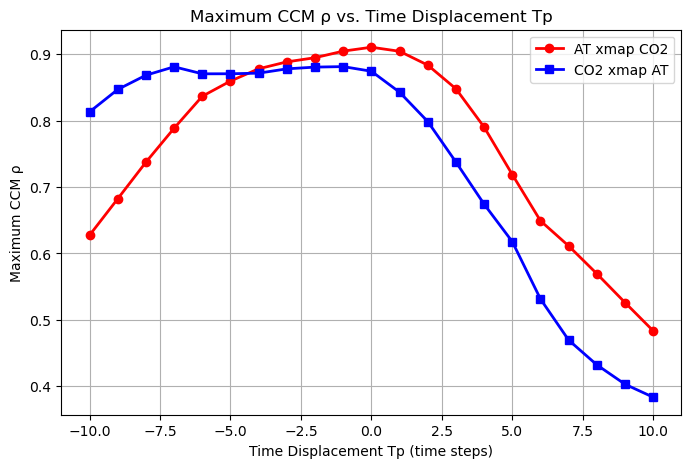

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


AT_data = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv")
CO2_data = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CO2.csv")


# # Read CSV files using pandas.
# AT_data = pd.read_csv('AT.csv')
# CO2_data = pd.read_csv('CO2.csv')

# Extract the variables of interest.
AT = AT_data['AT'].values
CO2 = CO2_data['CO2'].values

# Crop the data from index 50 onward.
AT = AT[49:]
CO2 = CO2[49:]

# Set CCM parameters.
E = 4       # Embedding dimension
tau = 2     # Time lag (in time steps)
b = E + 1   # Number of points used for simplex averaging

# Define the Tp (time displacement) range.
Tp_values = np.arange(-10, 11)  # from -10 to 10
nTp = len(Tp_values)

# Preallocate arrays for maximum CCM rho values.
max_rho_ATxmapCO2 = np.full(nTp, np.nan)  # using AT to predict CO2
max_rho_CO2xmapAT = np.full(nTp, np.nan)    # using CO2 to predict AT

n = len(AT)  # Both series are assumed to be of equal length.

# Define library parameters (hardcoded as in your MATLAB code).
Lmin_current = 40
Lmax_current = 360  # not used further because we fix Ls_current
Ls_current = 200

# Loop over each Tp value.
for i, Tp in enumerate(Tp_values):

    if Tp >= 0:
        idx = np.arange(0, n - Tp)
        shifted_AT = AT[idx]
        cropped_CO2 = CO2[idx + Tp]
    else:
        k = -Tp
        idx = np.arange(k, n)
        shifted_AT = AT[idx]
        cropped_CO2 = CO2[idx - k]
    
    if len(idx) < Lmin_current:
        continue  # skip if not enough data.
    
    # Run CCM: using shifted AT (predictor) to predict CO2.
    result1 = CCM_mat(shifted_AT, cropped_CO2, E, Ls_current, tau, b)
    max_rho_ATxmapCO2[i] = np.max(result1['rho'])
    
    # --- For CO2 xmap AT ---
    if Tp >= 0:
        idx = np.arange(0, n - Tp)
        shifted_CO2 = CO2[idx]
        cropped_AT = AT[idx + Tp]
    else:
        k = -Tp
        idx = np.arange(k, n)
        shifted_CO2 = CO2[idx]
        cropped_AT = AT[idx - k]
    
    result2 = CCM_mat(shifted_CO2, cropped_AT, E, Ls_current, tau, b)
    max_rho_CO2xmapAT[i] = np.max(result2['rho'])

# Plot Maximum CCM rho versus Time Displacement Tp.
plt.figure(figsize=(8, 5))
plt.plot(Tp_values, max_rho_ATxmapCO2, 'r-o', linewidth=2, label='AT xmap CO2')
plt.plot(Tp_values, max_rho_CO2xmapAT, 'b-s', linewidth=2, label='CO2 xmap AT')
plt.xlabel('Time Displacement Tp (time steps)')
plt.ylabel('Maximum CCM ρ')
plt.title('Maximum CCM ρ vs. Time Displacement Tp')
plt.legend()
plt.grid(True)
plt.show()
